In [ ]:
!pip install pip install opencv-python

In [ ]:
!pip install sagemaker boto3 --upgrade

In [5]:
!pip3 install ultralytics

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached ultralytics-8.0.114-py3-none-any.whl (595 kB)
  Using cached torchvision-0.15.2-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)


restart kernel after all installed

## Prepare Model

In [1]:
import os, sagemaker, subprocess, boto3
from datetime import datetime
from sagemaker import s3
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel
from sagemaker.deserializers import JSONDeserializer

In [2]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
sagemaker_default_bucket = sess.default_bucket()
region = sess.boto_session.region_name

In [6]:
from ultralytics import YOLO

## Choose a model:
model_name = 'yolov8l.pt'
YOLO(model_name)

100%|██████████| 83.7M/83.7M [00:00<00:00, 444MB/s]


Copy model file to code/ and tar the code/ path, also including processing code - inference.py

In [7]:
!cp {model_name} code/.
!tar -cpzf  model.tar.gz code/

Upload .tar.gz to s3 & sagemaker endpoint will pull it while deploying

In [12]:
YOUR_PATH = 'yolov8-test-deploy'

In [13]:
!aws s3 cp model.tar.gz s3://{sagemaker_default_bucket}/{YOUR_PATH}/

upload: ./model.tar.gz to s3://sagemaker-us-east-1-633205212955/yolov8-test-deploy/model.tar.gz


Register the model, with entry_point, .tar.gz s3 path, framework version, etc

In [14]:
model = PyTorchModel(entry_point='inference.py',
                     model_data=f's3://{sagemaker_default_bucket}/{YOUR_PATH}/model.tar.gz', 
                     framework_version='1.12', 
                     py_version='py38',
                     role=role,
                     env={'TS_MAX_RESPONSE_SIZE':'20000000', 'YOLOV8_MODEL': model_name},
                     sagemaker_session=sess)

Deploy model with Instance type & count

In [15]:
INSTANCE_TYPE = 'ml.m5.4xlarge'
ENDPOINT_NAME = 'yolov8-pytorch-' + str(datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S-%f'))

predictor = model.deploy(initial_instance_count=1, 
                         instance_type=INSTANCE_TYPE,
                         deserializer=JSONDeserializer(),
                         endpoint_name=ENDPOINT_NAME)

-------!

## Invocation

In [16]:
import boto3, cv2, time, numpy as np, matplotlib.pyplot as plt, random
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer

Check if SageMaker endpoint is ready
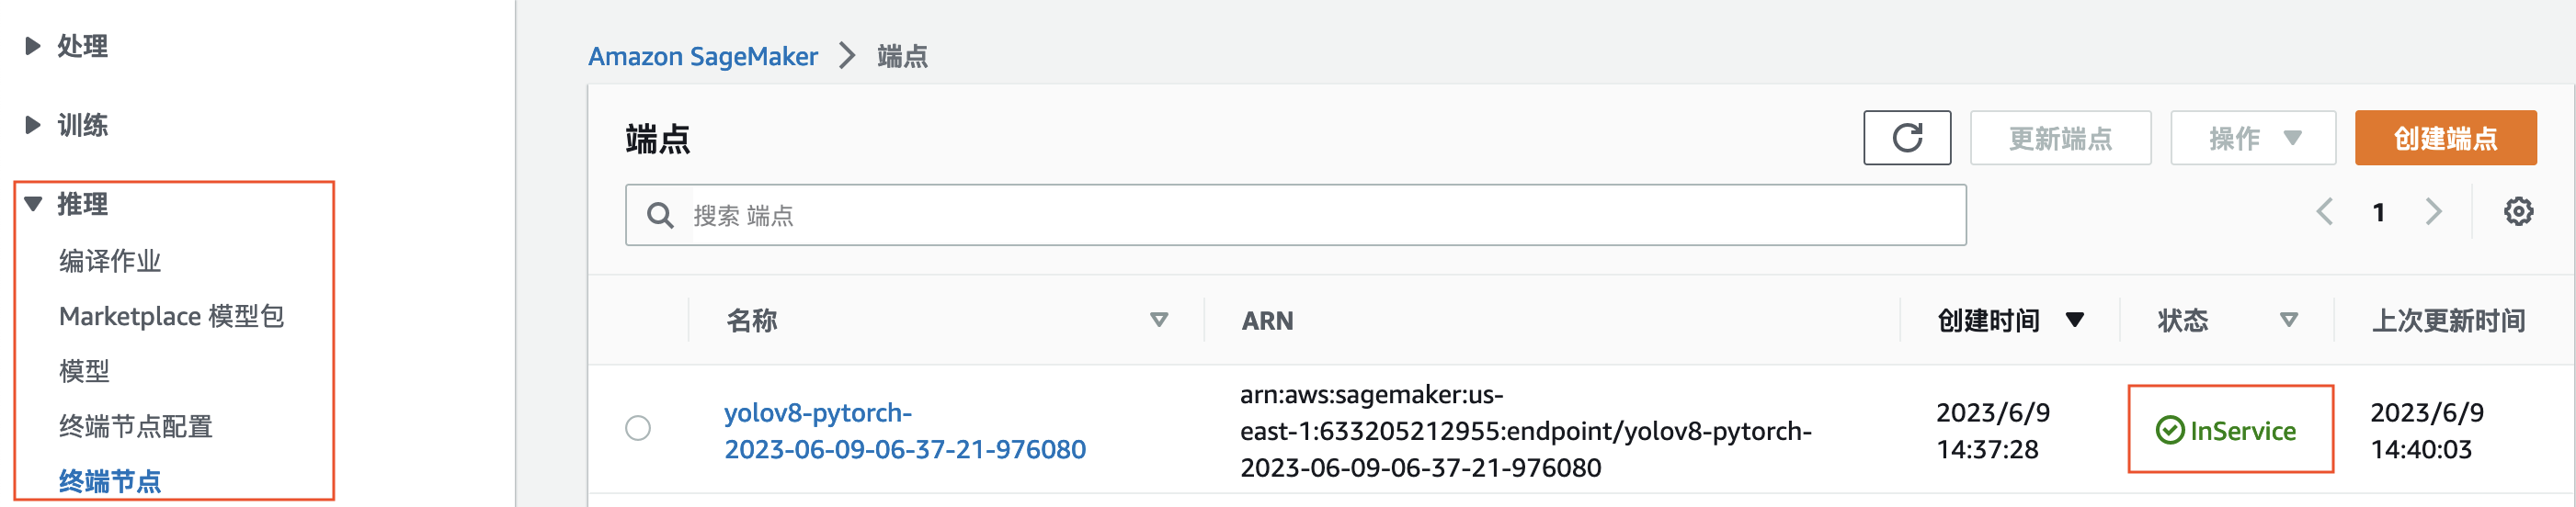

In [22]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

Inference Time = 1.0274 seconds


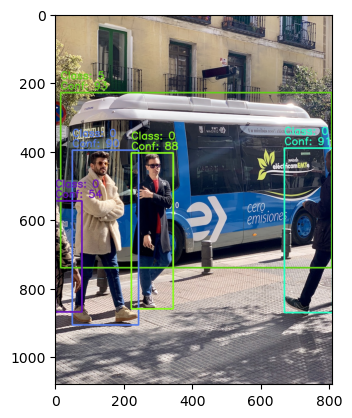

In [23]:
infer_start_time = time.time()

orig_image = cv2.imread('bus.jpg')

image_height, image_width, _ = orig_image.shape
model_height, model_width = 300, 300
x_ratio = image_width/model_width
y_ratio = image_height/model_height

resized_image = cv2.resize(orig_image, (model_height, model_width))
payload = cv2.imencode('.jpg', resized_image)[1].tobytes()
result = predictor.predict(payload)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

if 'boxes' in result:
    for idx,(x1,y1,x2,y2,conf,lbl) in enumerate(result['boxes']):
        # Draw Bounding Boxes
        x1, x2 = int(x_ratio*x1), int(x_ratio*x2)
        y1, y2 = int(y_ratio*y1), int(y_ratio*y2)
        color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
        cv2.rectangle(orig_image, (x1,y1), (x2,y2), color, 4)
        cv2.putText(orig_image, f"Class: {int(lbl)}", (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        cv2.putText(orig_image, f"Conf: {int(conf*100)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        if 'masks' in result:
            # Draw Masks
            mask = cv2.resize(np.asarray(result['masks'][idx]), dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            for c in range(3):
                orig_image[:,:,c] = np.where(mask>0.5, orig_image[:,:,c]*(0.5)+0.5*color[c], orig_image[:,:,c])

if 'probs' in result:
    # Find Class
    lbl = result['probs'].index(max(result['probs']))
    color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
    cv2.putText(orig_image, f"Class: {int(lbl)}", (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    
if 'keypoints' in result:
    # Define the colors for the keypoints and lines
    keypoint_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
    line_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))

    # Define the keypoints and the lines to draw
    # keypoints = keypoints_array[:, :, :2]  # Ignore the visibility values
    lines = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Torso
        (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
    ]

    # Draw the keypoints and the lines on the image
    for keypoints_instance in result['keypoints']:
        # Draw the keypoints
        for keypoint in keypoints_instance:
            if keypoint[2] == 0:  # If the keypoint is not visible, skip it
                continue
            cv2.circle(orig_image, (int(x_ratio*keypoint[:2][0]),int(y_ratio*keypoint[:2][1])), radius=5, color=keypoint_color, thickness=-1)

        # Draw the lines
        for line in lines:
            start_keypoint = keypoints_instance[line[0]]
            end_keypoint = keypoints_instance[line[1]]
            if start_keypoint[2] == 0 or end_keypoint[2] == 0:  # If any of the keypoints is not visible, skip the line
                continue
            cv2.line(orig_image, (int(x_ratio*start_keypoint[:2][0]),int(y_ratio*start_keypoint[:2][1])),(int(x_ratio*end_keypoint[:2][0]),int(y_ratio*end_keypoint[:2][1])), color=line_color, thickness=2)

plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.show()